In [143]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import random
import torch.nn.functional as F
import torch.nn.functional as func
import collections
from sklearn.model_selection import train_test_split
from collections import Counter
from utils.language_utils import word_to_indices, letter_to_vec
from utils.ShakeSpeare_reduce import ShakeSpeare

from models.lstm import *
from torchvision import datasets, transforms

v5.0

加上CNN+CIFAR10的实验

In [144]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # 解决由于多次加载 OpenMP 相关动态库而引起的冲突

In [145]:
# import sys
# print(sys.executable)

# print(torch.cuda.is_available())
# print(torch.cuda.get_device_capability())

# gpu_info = !nvidia-smi
# env = !env
# print(env)

# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.3.1
CUDA available: True


In [146]:

class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=100):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x

        return residual

# MobileNetV2（比lenet更复杂的CNN网络）网络中的线性瓶颈结构，原文中用于CIFAR-100任务
class MobileNetV2(nn.Module):

    def __init__(self, class_num=20):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(3, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x

    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))

        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1

        return nn.Sequential(*layers)

def mobilenetv2():
    return MobileNetV2()


# FedMut中采用的cnn模型
class CNNCifar(nn.Module):
    def __init__(self):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x, start_layer_idx=0, logit=False):
        if start_layer_idx < 0:  #
            return self.mapping(x, start_layer_idx=start_layer_idx, logit=logit)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        result = {'activation' : x}
        x = x.view(-1, 16 * 5 * 5)
        result['hint'] = x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        result['representation'] = x
        x = self.fc3(x)
        result['output'] = x
        return result

    def mapping(self, z_input, start_layer_idx=-1, logit=True):
        z = z_input
        z = self.fc3(z)

        result = {'output': z}
        if logit:
            result['logit'] = z
        return result
    
def cnncifar():
    return CNNCifar()



def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCifar10(nn.Module):

    def __init__(self, block, layers, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNetCifar10, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        result = {}
        x = self.layer1(x)
        result['activation1'] = x
        x = self.layer2(x)
        result['activation2'] = x
        x = self.layer3(x)
        result['activation3'] = x
        x = self.layer4(x)
        result['activation4'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        result['representation'] = x
        x = self.fc(x)
        result['output'] = x

        return result

    def mapping(self, z_input, start_layer_idx=-1, logit=True):
        z = z_input
        z = self.fc(z)

        result = {'output': z}
        if logit:
            result['logit'] = z
        return result

    def forward(self, x, start_layer_idx=0, logit=False):
        if start_layer_idx < 0:  #
            return self.mapping(x, start_layer_idx=start_layer_idx, logit=logit)
        return self._forward_impl(x)


def ResNet8(**kwargs):
    return ResNetCifar10(BasicBlock, [1, 1, 1], **kwargs)

def ResNet18_cifar10(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return ResNetCifar10(BasicBlock, [2, 2, 2, 2], **kwargs)



def ResNet50_cifar10(**kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return ResNetCifar10(Bottleneck, [3, 4, 6, 3], **kwargs)

In [147]:
# 新的测试：针对整个测试数据集的测试
def test_inference(net_glob, dataset_test):
    # testing
    acc_test, loss_test = test_img(net_glob, dataset_test)

    # print("Testing accuracy: {:.2f}".format(acc_test))

    return acc_test.item()

def test_img(net_g, datatest):
    net_g.eval()
    # testing
    # test loss代表在测试集上的平均损失（对测试数据的预测输出与真实标签的差距）
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=test_bc_size)
    l = len(data_loader)
    with torch.no_grad():
        for idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            log_probs = net_g(data)['output']
            # sum up batch loss
            test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
            # get the index of the max log-probability
            y_pred = log_probs.data.max(1, keepdim=True)[1]
            correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [148]:
# 将CIFAR-100的100个类别转为20个类别（粒度更粗，降低任务复杂度）
def sparse2coarse(targets):
    """Convert Pytorch CIFAR100 sparse targets to coarse targets.

    Usage:
        trainset = torchvision.datasets.CIFAR100(path)
        trainset.targets = sparse2coarse(trainset.targets)
    """
    coarse_labels = np.array([ 4,  1, 14,  8,  0,  6,  7,  7, 18,  3,
                               3, 14,  9, 18,  7, 11,  3,  9,  7, 11,
                               6, 11,  5, 10,  7,  6, 13, 15,  3, 15,
                               0, 11,  1, 10, 12, 14, 16,  9, 11,  5,
                               5, 19,  8,  8, 15, 13, 14, 17, 18, 10,
                               16, 4, 17,  4,  2,  0, 17,  4, 18, 17,
                               10, 3,  2, 12, 12, 16, 12,  1,  9, 19,
                               2, 10,  0,  1, 16, 12,  9, 13, 15, 13,
                              16, 19,  2,  4,  6, 19,  5,  5,  8, 19,
                              18,  1,  2, 15,  6,  0, 17,  8, 14, 13])
    return coarse_labels[targets]

In [149]:

# 共有6w个图像，其中5w训练，1w测试
def CIFAR100():
    '''Return Cifar100
    '''
    
    # 参考FedMut进行正则化变化
    trans_cifar100 = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )
    
    train_dataset = torchvision.datasets.CIFAR100(root='../data/CIFAR-100',
                                            train=True,
                                            transform=trans_cifar100,
                                            download=True)
    test_dataset = torchvision.datasets.CIFAR100(root='../data/CIFAR-100',
                                            train=False,
                                            transform=trans_cifar100,
                                            download=True)
    
    # 将图片转换成 numpy 数组格式，并对标签做了 coarse 处理
    total_img,total_label = [],[]
    for imgs,labels in train_dataset:
        total_img.append(imgs.numpy())
        total_label.append(labels)
    total_img = np.array(total_img)
    total_label = np.array(sparse2coarse(total_label))

    cifar = [total_img, total_label]
    
    return cifar, test_dataset

In [150]:
# 基于 Dirichlet 分布 来模拟non-IID。返回一个形状为 (client_num, class_num) 的概率矩阵，每一行代表一个客户端对各类别的概率分布。
def get_prob(non_iid, client_num, class_num = 20):
    # Modify：我之后加上的
    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
    
    return np.random.dirichlet(np.repeat(non_iid, class_num), client_num)

In [151]:
# 全部用于构建训练集
def create_data_all_train(prob, size_per_client, dataset, N=20):
    total_each_class = size_per_client * np.sum(prob, 0)
    data, label = dataset
    

    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
        random.seed(seed_num)

    # 为每个类别随机采样数据
    all_class_set = []
    for i in range(N):
        size = total_each_class[i]
        sub_data = data[label == i]
        sub_label = label[label == i]

        num_samples = int(size)
        if num_samples > len(sub_data):
            print(f"类别 {i} 的数据样本不足，采样数从 {num_samples} 调整为 {len(sub_data)}")
            num_samples = len(sub_data)
        rand_indx = np.random.choice(len(sub_data), size=num_samples, replace=False).astype(int)
        
        sub2_data, sub2_label = sub_data[rand_indx], sub_label[rand_indx]
        all_class_set.append((sub2_data, sub2_label))

    index = [0] * N
    clients = []

    for m in range(prob.shape[0]):  # 遍历客户端
        labels, images = [], []  # 训练数据

        for n in range(N):
            # 100%用于训练
            start, end = index[n], index[n] + int(prob[m][n] * size_per_client)
            image, label = all_class_set[n][0][start:end], all_class_set[n][1][start:end]

            # 记录当前类别的数据分配进度
            index[n] += int(prob[m][n] * size_per_client)

            labels.extend(label)
            images.extend(image)

        clients.append((np.array(images), np.array(labels)))

    return clients

# 80%构建训练集，20%构建测试集
def create_data(prob, size_per_client, dataset, N=20):
    total_each_class = size_per_client * np.sum(prob, 0)
    data, label = dataset

    # Modify：我之后加上的
    if data_random_fix:
        np.random.seed(seed_num)  # 固定种子，确保数据抽样一致
        random.seed(seed_num)

    # 为每个类别随机采样数据
    all_class_set = []
    for i in range(N):
        size = total_each_class[i]
        sub_data = data[label == i]
        sub_label = label[label == i]

        rand_indx = np.random.choice(len(sub_data), size=int(size), replace=False).astype(int)
        sub2_data, sub2_label = sub_data[rand_indx], sub_label[rand_indx]
        all_class_set.append((sub2_data, sub2_label))

    index = [0] * N
    clients, test = [], []

    for m in range(prob.shape[0]):  # 遍历客户端
        labels, images = [], []  # 训练数据
        tlabels, timages = [], [] # 测试数据

        for n in range(N):
            # 80%用于训练，20%用于测试
            # 这里的int向下取整，会导致实际的数据量比计算略小
            start, end = index[n], index[n] + int(prob[m][n] * size_per_client * 0.8)
            test_start, test_end = end, index[n] + int(prob[m][n] * size_per_client)

            image, label = all_class_set[n][0][start:end], all_class_set[n][1][start:end]
            test_image, test_label = all_class_set[n][0][test_start:test_end], all_class_set[n][1][test_start:test_end]

            # 记录当前类别的数据分配进度
            index[n] += int(prob[m][n] * size_per_client)

            labels.extend(label)
            images.extend(image)

            tlabels.extend(test_label)
            timages.extend(test_image)

        clients.append((np.array(images), np.array(labels)))
        test.append((np.array(timages), np.array(tlabels)))

    return clients, test

In [152]:

# 合并所有客户端的测试数据 （上面讲测试数据分成了不同的客户端）
# 但并没有使用，用途不明
def comb_client_test_func(client_test_data):
    comb_client_test_image = []
    comb_client_test_label = []
    for i in range(client_num):
        comb_client_test_image.extend(list(client_test_data[i][0]))
        comb_client_test_label.extend(list(client_test_data[i][1]))
    
    # 将测试图片和标签合并为 numpy 数组
    comb_client_test_image = np.array(comb_client_test_image)
    comb_client_test_label = np.array(comb_client_test_label)
    
    label_count = Counter(comb_client_test_label)
    print("测试集类别分布：")
    for label, count in sorted(label_count.items()):
        print(f"类别 {label}: {count} 个样本")
    
    return [comb_client_test_image, comb_client_test_label]

In [153]:
# 样服务器子集的函数
def select_server_subset(cifar, percentage=0.1, mode='iid', dirichlet_alpha=1.0):
    """
    从 cifar 数据集中挑选服务器数据子集（cifar 已经是 [N, C, H, W] 格式）。
    
    参数：
      - cifar: 一个列表，格式为 [images, labels]，images 形状为 [N, C, H, W]
      - percentage: 挑选比例，例如 0.1 表示取 10% 的数据
      - mode: 'iid' 表示各类别均匀采样；'non-iid' 表示使用 Dirichlet 分布采样
      - dirichlet_alpha: 当 mode 为 'non-iid' 时的 Dirichlet 分布参数
    返回：
      - subset_images: 选出的图片数组（numpy.array）
      - subset_labels: 选出的标签数组（numpy.array）
    """
    images, labels = cifar
    unique_classes = np.unique(labels)
    total_num = len(labels)
    server_total = int(total_num * percentage)
    
    selected_indices = []
    
    if mode == 'iid':
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            num_cls = int(len(cls_indices) * percentage)
            if num_cls > len(cls_indices):
                num_cls = len(cls_indices)
            sampled = np.random.choice(cls_indices, size=num_cls, replace=False)
            selected_indices.extend(sampled)
    elif mode == 'non-iid':
        num_classes = len(unique_classes)
        prob = np.random.dirichlet(np.repeat(dirichlet_alpha, num_classes))
        cls_sample_numbers = {}
        total_assigned = 0
        for i, cls in enumerate(unique_classes):
            n_cls = int(prob[i] * server_total)
            cls_sample_numbers[cls] = n_cls
            total_assigned += n_cls
        diff = server_total - total_assigned
        if diff > 0:
            for cls in np.random.choice(unique_classes, size=diff, replace=True):
                cls_sample_numbers[cls] += 1
        
        for cls in unique_classes:
            cls_indices = np.where(labels == cls)[0]
            n_sample = cls_sample_numbers[cls]
            if n_sample > len(cls_indices):
                n_sample = len(cls_indices)
            sampled = np.random.choice(cls_indices, size=n_sample, replace=False)
            selected_indices.extend(sampled)
    else:
        raise ValueError("mode 参数必须为 'iid' 或 'non-iid'")
    
    selected_indices = np.array(selected_indices)
    np.random.shuffle(selected_indices)
    
    subset_images = images[selected_indices]
    subset_labels = labels[selected_indices]
    
    return subset_images, subset_labels


In [154]:
# 本地训练并更新权重，返回更新后的模型权重、平均训练损失以及第一个迭代的梯度信息
def update_weights(model_weight, dataset, learning_rate, local_epoch):
    if origin_model == 'resnet':
        model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        model = CharLSTM().to(device)
    elif origin_model == "cnn":
        model = cnncifar().to(device)
    
    model.load_state_dict(model_weight)

    model.train()
    epoch_loss = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    if origin_model == 'resnet' or 'cnn':
        Tensor_set = TensorDataset(torch.Tensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    elif origin_model == 'lstm':
        Tensor_set = TensorDataset(torch.LongTensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    
    data_loader = DataLoader(Tensor_set, batch_size=bc_size, shuffle=True)

    first_iter_gradient = None  # 初始化变量来保存第一个iter的梯度

    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(data_loader):
            model.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['output'], labels.long())
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item()/images.shape[0])

            # 保存第一个iter的梯度
            if iter == 0 and batch_idx == 0:
                first_iter_gradient = {}
                for name, param in model.named_parameters():
                    first_iter_gradient[name] = param.grad.clone()
                # 保存 BatchNorm 层的 running mean 和 running variance
                for name, module in model.named_modules():
                    if isinstance(module, nn.BatchNorm2d):
                        first_iter_gradient[name + '.running_mean'] = module.running_mean.clone()
                        first_iter_gradient[name + '.running_var'] = module.running_var.clone()

        epoch_loss.append(sum(batch_loss)/len(batch_loss))

    return model.state_dict(), sum(epoch_loss) / len(epoch_loss), first_iter_gradient


In [155]:
# 计算模型权重的差异，并根据学习率 lr 对权重差异进行缩放
def weight_differences(n_w, p_w, lr):
    w_diff = copy.deepcopy(n_w)
    for key in w_diff.keys():
        if 'num_batches_tracked' in key:
            continue
        w_diff[key] = (p_w[key] - n_w[key]) * lr
    return w_diff

In [156]:
# 也是本地训练，不过引入了Fed-C的权重修正机制
def update_weights_correction(model_weight, dataset, learning_rate, local_epoch, c_i, c_s):
    if origin_model == 'resnet':
        model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        model = CharLSTM().to(device)
    elif origin_model == "cnn":
        model = cnncifar().to(device)
        
    model.load_state_dict(model_weight)

    model.train()
    epoch_loss = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    if origin_model == 'resnet' or 'cnn':
        Tensor_set = TensorDataset(torch.Tensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
    elif origin_model == 'lstm':
        Tensor_set = TensorDataset(torch.LongTensor(dataset[0]).to(device), torch.Tensor(dataset[1]).to(device))
        
    data_loader = DataLoader(Tensor_set, batch_size=bc_size, shuffle=True)

    for iter in range(local_epoch):
        batch_loss = []
        for batch_idx, (images, labels) in enumerate(data_loader):
            model.zero_grad()
            outputs = model(images)
            loss = criterion(outputs['output'], labels.long())
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.sum().item()/images.shape[0])
        epoch_loss.append(sum(batch_loss)/len(batch_loss))
        corrected_graident = weight_differences(c_i, c_s, learning_rate)
        orginal_model_weight = model.state_dict()
        corrected_model_weight = weight_differences(corrected_graident, orginal_model_weight, 1)  # 这里缩放权重为1
        model.load_state_dict(corrected_model_weight)

    return model.state_dict(),  sum(epoch_loss) / len(epoch_loss)

In [157]:
def average_weights(w):
    """
    Returns the average of the weights.
    """
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        if 'num_batches_tracked' in key:
            continue
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [158]:
# baseline: server-only
def server_only(initial_w, global_round, gamma, E):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    
    
    for round in tqdm(range(global_round)):
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        # Server side local training

                
        update_server_w, round_loss, _ = update_weights(train_w, server_data, gamma, E)
        train_w = update_server_w
        test_model.load_state_dict(train_w)
        train_loss.append(round_loss)
        
        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        # Test Accuracy
        # test_a = 0
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
        # print(test_a)
    return test_acc, train_loss

In [159]:
def fedavg(initial_w, global_round, eta, K, M):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    for round in tqdm(range(global_round)):
        local_weights, local_loss = [], []
        # Client side local training
        # if eta > 0.001:
        #     eta = eta * 0.99
        sampled_client = random.sample(range(client_num), M)
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)

        train_w = average_weights(local_weights)

        # Test Accuracy
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)
        
        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
            
        # test_a = 0
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
#         print(test_a)
    return test_acc, train_loss


In [160]:
def hybridFL(initial_w, global_round, eta, K, M):
    """
    HybridFL算法：FedAvg改进，服务器也作为一个普通客户端参与训练。
    
    参数:
    - initial_w: 初始模型权重
    - global_round: 全局训练轮数
    - eta: 学习率
    - K: 本地训练轮数
    - M: 每轮采样的客户端数量
    """
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)     # 当前全局权重
    test_acc = []                          # 保存每轮测试精度
    train_loss = []                        # 保存每轮训练损失
    
    for round in tqdm(range(global_round)):
        local_weights, local_loss = [], []  # 存储每个客户端/服务器的权重和损失

        # 随机采样 M 个客户端
        sampled_client = random.sample(range(client_num), M)

        # 客户端本地训练
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)

        # 服务器参与训练
        update_server_w, server_round_loss, _ = update_weights(train_w, server_data, eta, K)
        local_weights.append(update_server_w)   # 将服务器权重加入列表
        local_loss.append(server_round_loss)    # 将服务器损失加入列表

        # 权重聚合
        train_w = average_weights(local_weights)

        # 评估模型性能
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss) / len(local_loss)
        train_loss.append(loss_avg)

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        
        # test_a = 0
        # for i in client_test_data:  # 遍历所有客户端测试数据
        #     ac = test_inference(test_model, i)[0]
        #     test_a += ac
        # test_a = test_a / len(client_test_data)
        # test_acc.append(test_a)
        
        # # 打印每轮的结果
        # print(f"Round {round + 1}: Test Accuracy = {test_a:.4f}, Train Loss = {loss_avg:.4f}")
    
    return test_acc, train_loss


In [161]:
def CLG_SGD(initial_w, global_round, eta, gamma, K, E, M):
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(initial_w)
    test_acc = []
    train_loss = []
    
    for round in tqdm(range(global_round)):
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        sampled_client = random.sample(range(client_num), M)
        for i in sampled_client:
            update_client_w, client_round_loss, _ = update_weights(train_w, client_data[i], eta, K)
            local_weights.append(update_client_w)
            local_loss.append(client_round_loss)
        train_w = average_weights(local_weights)
        # Server side local training
    
        
        update_server_w, round_loss, _ = update_weights(train_w, server_data, gamma, E)
        train_w = update_server_w
        local_loss.append(round_loss)

        # Test Accuracy
        test_model.load_state_dict(train_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损失

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))
    
        # test_a = 0
        # # 遍历客户端测试数据，计算平均准确率
        # for i in client_test_data:
        #     ac = test_inference(test_model,i)[0]
        #     test_a = test_a + ac
        # test_a = test_a/len(client_test_data)
        # test_acc.append(test_a)
#         print(test_a)
    return test_acc, train_loss

In [162]:
def FedMut(net_glob, global_round, eta, K, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
        
    max_rank = 0
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_agg)
        
        # Test Accuracy
        test_model.load_state_dict(w_agg)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端的平均损失

        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(w_agg, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, w_agg, M, w_delta, alpha
        )

    return test_acc, train_loss   

In [163]:

# Mutation方向设置为server更新的方向
def CLG_Mut(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    delta_list = []
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    w_old_s1 = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损失


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(update_server_w, w_agg, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


# 将mutation的方向设置为新方向（server更新之后）减去上一轮全局方向（其余不变）
def CLG_Mut_2(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    delta_list = []
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    w_old_s1 = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)
        
        
        # copy weight to net_glob
        net_glob.load_state_dict(update_server_w)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照server训练的方向，进行mutation
        w_delta = FedSub(update_server_w, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


# 将mutation的方向设置为client训练更新的方向
def CLG_Mut_3(net_glob, global_round, eta, gamma, K, E, M):
    
    net_glob.train()
    
    if origin_model == 'resnet':
        test_model = ResNet18_cifar10().to(device)
    elif origin_model == "lstm":
        test_model = CharLSTM().to(device)
    elif origin_model == "cnn":
        test_model = cnncifar().to(device)
        
    train_w = copy.deepcopy(net_glob.state_dict())
    test_acc = []
    train_loss = []
    
    w_locals = []
    for i in range(M):
        w_locals.append(copy.deepcopy(net_glob.state_dict()))
    
    delta_list = []
    max_rank = 0
    w_old = copy.deepcopy(net_glob.state_dict())
    w_old_s1 = copy.deepcopy(net_glob.state_dict())
    
    for round in tqdm(range(global_round)):
        w_old = copy.deepcopy(net_glob.state_dict())
        
        # 学习率衰减，这里默认注释掉了
        # if eta > 0.001:
        #     eta = eta * 0.99
        # if gamma > 0.001:
        #     gamma = gamma * 0.99
        local_weights, local_loss = [], []
        # Client side local training
        # 从总共client_num客户端中选择M个训练
        idxs_users = np.random.choice(range(client_num), M, replace=False)
        for i, idx in enumerate(idxs_users):
            net_glob.load_state_dict(w_locals[i])
            
            update_client_w, client_round_loss, _ = update_weights(copy.deepcopy(net_glob.state_dict()), client_data[idx], eta, K)
            w_locals[i] = copy.deepcopy(update_client_w)
            local_loss.append(client_round_loss)

        # Global Model Generation
        w_agg = Aggregation(w_locals, None)  
        
        # Server side local training
        update_server_w, round_loss, _ = update_weights(w_agg, server_data, gamma, E)
        local_loss.append(round_loss)
        
        
        # copy weight to net_glob
        net_glob.load_state_dict(update_server_w)

        # Test Accuracy
        test_model.load_state_dict(update_server_w)
        loss_avg = sum(local_loss)/ len(local_loss)
        train_loss.append(loss_avg)   # 计算所有客户端和服务器一起的平均损


        # 新的测试（针对全部测试数据进行）
        test_acc.append(test_inference(test_model, test_dataset))

        # 按照client训练的方向，进行mutation
        w_delta = FedSub(w_agg, w_old, 1.0)
        # 计算模型更新w_delta的L2范数（平方和），衡量模型更新程度的大小
        rank = delta_rank(w_delta)
        # print(rank)
        if rank > max_rank:
            max_rank = rank
        alpha = radius  # 论文中的alpha，衡量Mutation的幅度
        # alpha = min(max(args.radius, max_rank/rank),(10.0-args.radius) * (1 - iter/args.epochs) + args.radius)
        w_locals = mutation_spread(
            round, update_server_w, M, w_delta, alpha
        )

    return test_acc, train_loss


def mutation_spread(iter, w_glob, m, w_delta, alpha):

    w_locals_new = []
    ctrl_cmd_list = []
    ctrl_rate = mut_acc_rate * (
        1.0 - min(iter * 1.0 / mut_bound, 1.0)
    )  # 论文中的βt，随着iter逐渐从β0减小到0

    # k代表模型中的参数数量，对每个参数按照client数量分配v（论文中是按照每一层分配）
    for k in w_glob.keys():
        ctrl_list = []
        for i in range(0, int(m / 2)):
            ctrl = random.random()  # 随机数，范围：[0,1)
            # 这里分ctrl感觉没什么必要，shuffle后都会随机掉
            if ctrl > 0.5:
                ctrl_list.append(1.0)
                ctrl_list.append(1.0 * (-1.0 + ctrl_rate))
            else:
                ctrl_list.append(1.0 * (-1.0 + ctrl_rate))
                ctrl_list.append(1.0)
        random.shuffle(ctrl_list)  # 打乱列表
        ctrl_cmd_list.append(ctrl_list)
    cnt = 0
    for j in range(m):
        w_sub = copy.deepcopy(w_glob)
        if not (cnt == m - 1 and m % 2 == 1):
            ind = 0
            for k in w_sub.keys():
                w_sub[k] = w_sub[k] + w_delta[k] * ctrl_cmd_list[ind][j] * alpha
                ind += 1
        cnt += 1
        w_locals_new.append(w_sub)

    return w_locals_new



# 加权平均聚合，lens代表了权重，如果没有定义就是普通平均（FedMut就每定义）
def Aggregation(w, lens):
    w_avg = None
    if lens == None:
        total_count = len(w)
        lens = []
        for i in range(len(w)):
            lens.append(1.0)
    else:
        total_count = sum(lens)

    for i in range(0, len(w)):
        if i == 0:
            w_avg = copy.deepcopy(w[0])
            for k in w_avg.keys():
                w_avg[k] = w[i][k] * lens[i]
        else:
            for k in w_avg.keys():
                w_avg[k] += w[i][k] * lens[i]

    for k in w_avg.keys():
        w_avg[k] = torch.div(w_avg[k], total_count)

    return w_avg



def FedSub(w, w_old, weight):
    w_sub = copy.deepcopy(w)
    for k in w_sub.keys():
        w_sub[k] = (w[k] - w_old[k]) * weight

    return w_sub

def delta_rank(delta_dict):
    cnt = 0
    dict_a = torch.Tensor(0)
    s = 0
    for p in delta_dict.keys():
        a = delta_dict[p]
        a = a.view(-1)
        if cnt == 0:
            dict_a = a
        else:
            dict_a = torch.cat((dict_a, a), dim=0)

        cnt += 1
        # print(sim)
    s = torch.norm(dict_a, dim=0)
    return s



In [164]:
# 随机性（这里暂时不采用，先固定为false）
data_random_fix = False  # 是否固定数据采样的随机性
seed_num = 42
# 新采用的全局随机性机制
random_fix = True
seed = 2

GPU = 1  # 决定使用哪个gpu 0或1
verbose = False  # 调试模式，输出一些中间信息

client_num = 100
non_iid = 0.5  # Dirichlet 分布参数，数值越小数据越不均匀可根据需要调整
size_per_client = 400  # 每个客户端的数据量（训练）

server_iid = True # True代表server数据iid分布，否则为Non-iid分布
server_percentage = 0.1  # 服务器端用于微调的数据比例

# 模型相关
origin_model = 'resnet' # 采用模型

momentum = 0.5
weight_decay = 0  # 模型权重衰减参数，强制参数向0靠拢（和学习率衰减不一样！）这个是给我的原始代码中就是这样（设为0表示不引入）
bc_size = 50
test_bc_size = 128
num_classes = 20  # 分别数量，CIFAR100中是20, CIFAR10是10

# 联邦训练的超参数
global_round = 5  # 全局训练轮数，可根据需要调整
eta = 0.01  # 客户端端学习率，从{0.01, 0.1, 1}中调优
gamma = 0.01  # 服务器端学习率 从{0.005， 0.05， 0.5中调有}
K = 5  # 客户端本地训练轮数，从1，3，5中选
E = 1  # 服务器本地训练轮数，从1，3，5中选
M = 10  # 每一轮抽取客户端

# FedMut中参数
radius = 4.0  # alpha，控制mutation的幅度
mut_acc_rate = 0.3  # 论文中的β0
mut_bound = 50  # Tb

In [165]:

def set_random_seed(seed):
    """
        set random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


device = torch.device("cuda:" + str(GPU) if torch.cuda.is_available else 'cpu')

# 固定随机数
if random_fix:
    set_random_seed(seed)

if origin_model == 'resnet':
# 准备CIFAR100数据集
    cifar, test_dataset = CIFAR100()
    prob = get_prob(non_iid, client_num, class_num=20)
    client_data = create_data_all_train(prob, size_per_client, cifar, N=20)   # 这里改为全部构建训练集

    # 将测试标签转换为粗类别
    test_dataset.targets = sparse2coarse(test_dataset.targets)

    # 如果需要确保测试标签为整数类型
    test_dataset.targets = test_dataset.targets.astype(int)


    #CIFAR1--IID 挑选服务器子集：
    if server_iid:
        server_images, server_labels = select_server_subset(cifar, percentage=server_percentage, mode='iid')
    else:
        server_images, server_labels = select_server_subset(cifar, percentage=server_percentage,
                                                        mode='non-iid', dirichlet_alpha=0.5)

    init_model = ResNet18_cifar10().to(device)
    initial_w = copy.deepcopy(init_model.state_dict())
elif origin_model =='lstm':
    # 准备shakespeare数据集
    train_dataset = ShakeSpeare(True)
    test_dataset = ShakeSpeare(False)

    total_shake,total_label = [],[]
    for item,labels in train_dataset:
        total_shake.append(item.numpy())
        total_label.append(labels)
    total_shake = np.array(total_shake)
    total_label = np.array(total_label)

    shake = [total_shake, total_label]

    # 构建每个client的数据量
    dict_users = train_dataset.get_client_dic()

    # 统计类别数量
    unique_classes = np.unique(total_label)
    num_classes = len(unique_classes)
    print("shake数据集中类别数量：", num_classes)
    # 对于每个类别计算样本数量
    class_counts = [np.sum(total_label == cls) for cls in unique_classes]
    # 将数量转换成字符串后，用逗号隔开，并打印（只输出数字）
    print(", ".join(map(str, class_counts)))

    # 统计客户端数量
    num_clients = len(dict_users)
    print("shake数据集中客户端数量：", num_clients)

    # 构建client_data
    client_data = []
    for client in sorted(dict_users.keys()):
        indices = np.array(list(dict_users[client]), dtype=np.int64)
        client_images = total_shake[indices]
        client_labels = total_label[indices]
        client_data.append((client_images, client_labels))

    # Shake 挑选服务器子集，通过 Dirichlet 分布参数控制（例如 dirichlet_alpha=0.5）：
    if server_iid:
        server_images, server_labels = select_server_subset(shake, percentage=server_percentage,
                                                      mode='iid')
    else:
        server_images, server_labels = select_server_subset(shake, percentage=server_percentage,
                                                        mode='non-iid', dirichlet_alpha=0.5)

    # Shakespeare —— 用FedMut中提出的LSTM网络
    init_model = CharLSTM().to(device)
    initial_w = copy.deepcopy(init_model.state_dict())
elif origin_model == "cnn":
    trans_cifar10_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    trans_cifar10_val = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    
    dataset_train = datasets.CIFAR10(
        "./data/cifar10", train=True, download=True, transform=trans_cifar10_train
    )
    dataset_test = datasets.CIFAR10(
        "./data/cifar10", train=False, download=True, transform=trans_cifar10_val
    )
    
    # 输出训练集和测试集的大小
    print(f"Origin CIFAR10 Training set size: {len(dataset_train)}")
    print(f"Origin CIFAR10 Test set size origin: {len(dataset_test)}")
    
    
    # 将训练集图像数据与标签转换成 numpy 数组（与 CIFAR-100 部分类似）
    total_img, total_label = [], []
    for img, label in dataset_train:
        total_img.append(np.array(img))
        total_label.append(label)
    total_img = np.array(total_img)
    total_label = np.array(total_label)
    cifar = [total_img, total_label]

   # 根据 Dirichlet 分布生成客户端数据概率矩阵（注意：这里类别数为10）
    prob = get_prob(non_iid, client_num, class_num=10)
    
    # 构造每个客户端的本地数据（这里依然使用 create_data_all_train）
    client_data = create_data_all_train(prob, size_per_client, cifar, N=10)
    
    
    # 从训练集挑选出服务器训练使用的数据子集
    if server_iid:
        server_images, server_labels = select_server_subset(
            cifar, percentage=server_percentage, mode="iid"
        )
    else:
        server_images, server_labels = select_server_subset(
            cifar, percentage=server_percentage, mode="non-iid", dirichlet_alpha=0.5
        )
        
    # 初始化基于 CNN 的模型，这里使用你已定义好的 CNNCifar 网络
    init_model = cnncifar().to(device)
    initial_w = copy.deepcopy(init_model.state_dict())
    


#  打印数据集情况
all_images = []
all_labels = []
for data in client_data:
    all_images.extend(data[0])
    all_labels.extend(data[1])
comb_client_data = [np.array(all_images), np.array(all_labels)]

# 输出comb_client_data情况
imgs, lbls = comb_client_data
lbls = np.array(lbls)
total_count = len(lbls)
unique_classes, counts = np.unique(lbls, return_counts=True)

num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别
class_counts = [0] * num_classes

for cls, cnt in zip(unique_classes, counts):
    class_counts[cls] = cnt

# 打印格式：Total: 总数 类别0计数 类别1计数 ... 类别19计数
print("Traning Client Total: {}".format(" ".join([str(total_count)] + [str(c) for c in class_counts])))


# 打印每个客户端训练数据情况（只输出前10个）
for i, (imgs, lbls) in enumerate(client_data[:10]):
    lbls = np.array(lbls)
    total_count = len(lbls)
    unique_classes, counts = np.unique(lbls, return_counts=True)
    
    num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别
    class_counts = [0] * num_classes
    
    for cls, cnt in zip(unique_classes, counts):
        class_counts[cls] = cnt
    # 打印格式：Client i: 总数 类别0计数 类别1计数 ... 类别19计数
    print("Client {}: {}".format(i, " ".join([str(total_count)] + [str(c) for c in class_counts])))
    

# 为了与后续代码兼容，这里将 server_data 定义为一个列表：[images, labels]
server_data = [server_images, server_labels]

# # 输出测试集数据
# total_count = len(test_dataset)
# labels = np.array(test_dataset.label)
# _, counts = np.unique(labels, return_counts=True)

# print(f"测试集总数量 {total_count}")
# print(", ".join(str(c) for c in counts))

# 打印服务器数据情况
s_imgs, s_lbls = server_data
s_lbls = np.array(s_lbls)
total_count = len(s_lbls)
unique_classes, counts = np.unique(s_lbls, return_counts=True)

num_classes = int(unique_classes.max()) + 1  # 列表长度应该为最大类别+1
class_counts = [0] * num_classes

for cls, cnt in zip(unique_classes, counts):
    class_counts[cls] = cnt
# 输出格式: Server: 总数 类别0计数 类别1计数 ... 类别19计数
print("Server: {}".format(" ".join([str(total_count)] + [str(c) for c in class_counts])))
# print("  前5个标签: ", lbls[:5])
# print("  前5个数据形状: ", [server_data[0][j].shape for j in range(min(5, len(server_data[0])))])


# 初始化结果存储字典
results_test_acc = {}
results_train_loss = {}

# CLG_Mut 训练
test_acc_CLG_Mut, train_loss_CLG_Mut = CLG_Mut(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
results_test_acc['CLG_Mut'] = test_acc_CLG_Mut
results_train_loss['CLG_Mut'] = train_loss_CLG_Mut

# CLG_Mut_2 训练
test_acc_CLG_Mut_2, train_loss_CLG_Mut_2 = CLG_Mut_2(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
results_test_acc['CLG_Mut_2'] = test_acc_CLG_Mut_2
results_train_loss['CLG_Mut_2'] = train_loss_CLG_Mut_2

# CLG_Mut_3 训练
test_acc_CLG_Mut_3, train_loss_CLG_Mut_3 = CLG_Mut_3(copy.deepcopy(init_model), global_round, eta, gamma, K, E, M)
results_test_acc['CLG_Mut_3'] = test_acc_CLG_Mut_3
results_train_loss['CLG_Mut_3'] = train_loss_CLG_Mut_3


# FedMut 训练
test_acc_FedMut, train_loss_FedMut = FedMut(copy.deepcopy(init_model), global_round, eta, K, M)
results_test_acc['FedMut'] = test_acc_FedMut
results_train_loss['FedMut'] = train_loss_FedMut

# Server-only 训练
test_acc_server_only, train_loss_server_only = server_only(initial_w, global_round, gamma, E)
results_test_acc['Server_only'] = test_acc_server_only
results_train_loss['Server_only'] = train_loss_server_only

# FedAvg 训练
test_acc_fedavg, train_loss_fedavg = fedavg(initial_w, global_round, eta, K, M)
results_test_acc['FedAvg'] = test_acc_fedavg
results_train_loss['FedAvg'] = train_loss_fedavg

# CLG_SGD 训练
test_acc_CLG_SGD, train_loss_CLG_SGD = CLG_SGD(initial_w, global_round, eta, gamma, K, E, M)
results_test_acc['CLG_SGD'] = test_acc_CLG_SGD
results_train_loss['CLG_SGD'] = train_loss_CLG_SGD

# 如果存在至少20轮训练，则输出第二十轮的测试精度和训练损失
for algo in results_test_acc:
    if len(results_test_acc[algo]) >= 20:
        print(f"{algo} - 第二十轮测试精度: {results_test_acc[algo][19]:.2f}%, 第二十轮训练损失: {results_train_loss[algo][19]:.4f}")

print("\n")

# 打印最终训练结果
for algo in results_test_acc:
    print(f"{algo} - 最终测试精度: {results_test_acc[algo][-1]:.2f}%, 最终训练损失: {results_train_loss[algo][-1]:.4f}")


Files already downloaded and verified
Files already downloaded and verified
类别 4 的数据样本不足，采样数从 2742 调整为 2500
Traning Client Total: 38885 1661 1663 1791 2008 2500 1822 1768 1941 1615 1523 2432 1956 2023 1663 1813 1833 2189 2426 2437 1821
Client 0: 389 11 6 1 3 15 0 1 46 44 0 1 1 8 16 9 33 0 124 58 12
Client 1: 390 5 7 3 1 195 24 20 2 6 1 29 24 12 6 3 18 1 12 0 21
Client 2: 389 84 56 3 22 4 10 23 25 22 18 3 0 0 5 0 2 13 72 0 27
Client 3: 393 69 34 46 2 0 6 0 0 25 72 20 20 10 9 12 0 10 41 12 5
Client 4: 391 20 4 5 0 13 1 59 54 7 4 40 32 69 0 1 24 9 31 18
Client 5: 390 7 57 23 4 16 91 5 5 32 2 34 0 11 1 1 23 1 59 18
Client 6: 390 0 10 2 15 39 33 0 3 44 7 6 4 0 0 0 68 17 1 47 94
Client 7: 391 12 5 26 0 119 3 1 1 0 0 2 8 4 3 25 4 7 13 104 54
Client 8: 392 0 4 39 7 0 13 44 132 10 0 45 8 8 0 42 5 6 25 4
Client 9: 390 2 13 4 40 13 0 33 4 6 7 17 11 32 0 15 2 21 150 14 6
Server: 5000 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250


100%|██████████| 5/5 [00:30<00:00,  6.11s/it]



CLG_Mut - 最终测试精度: 31.15%, 最终训练损失: 0.0311
CLG_Mut_2 - 最终测试精度: 31.82%, 最终训练损失: 0.0262
CLG_Mut_3 - 最终测试精度: 29.88%, 最终训练损失: 0.0279
FedMut - 最终测试精度: 18.10%, 最终训练损失: 0.0318
Server_only - 最终测试精度: 27.58%, 最终训练损失: 0.0425
FedAvg - 最终测试精度: 20.47%, 最终训练损失: 0.0373
CLG_SGD - 最终测试精度: 28.36%, 最终训练损失: 0.0279


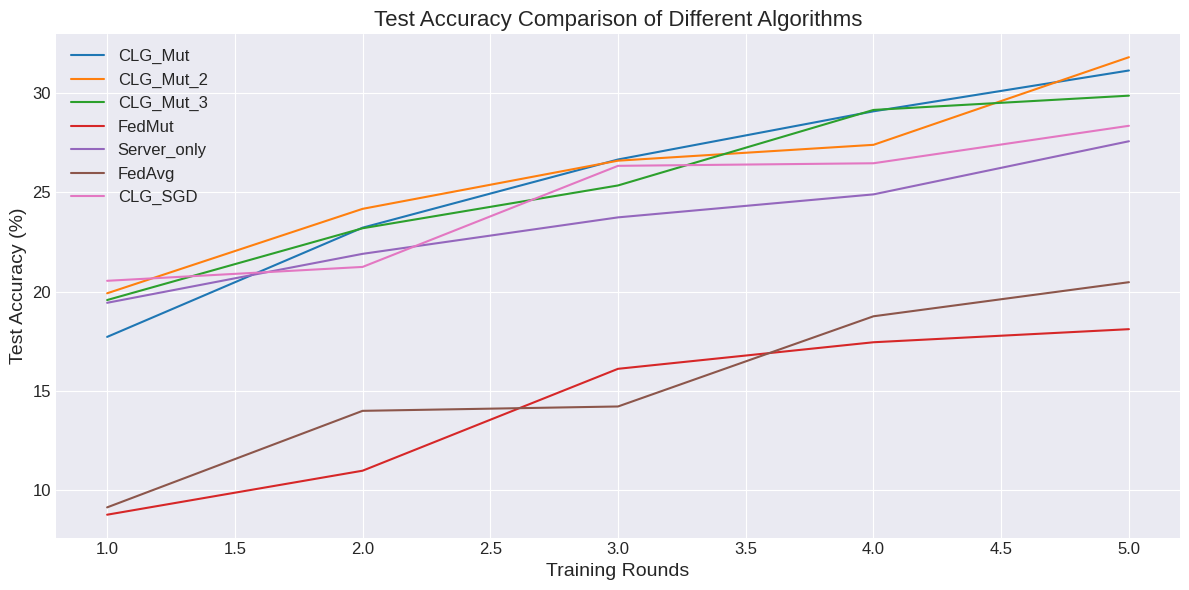

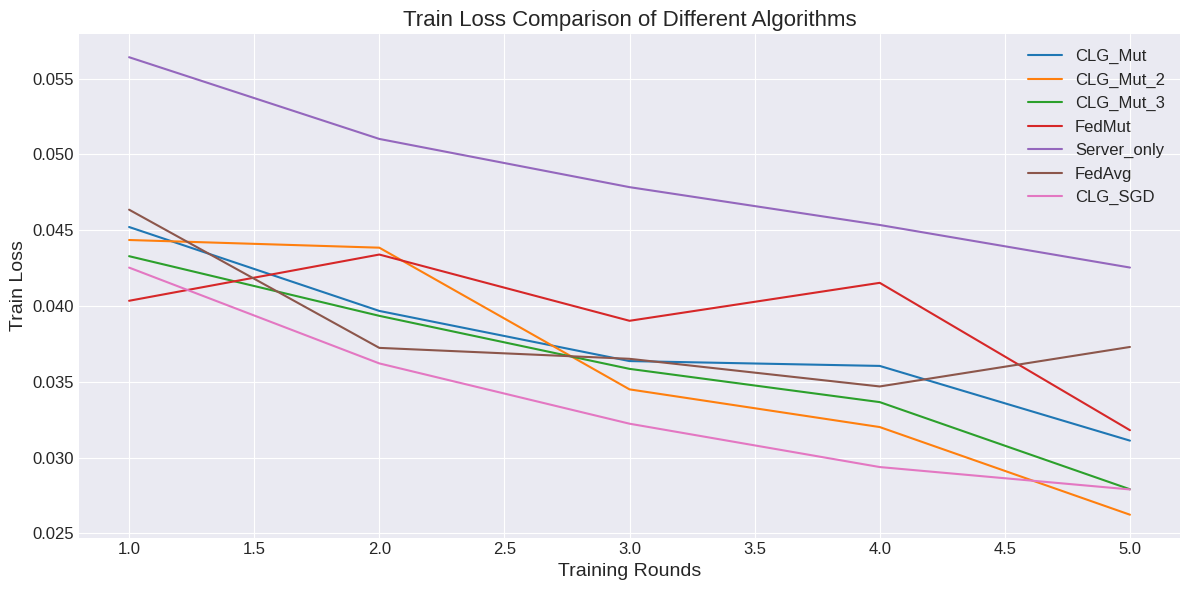

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import platform
import datetime


# 定义训练轮数
rounds = range(1, global_round + 1)

# 设置绘图风格（可选）
plt.style.use('seaborn-v0_8-darkgrid')

# 获取当前时间戳，格式为 YYYYmmdd_HHMMSS
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Plot Test Accuracy Comparison
plt.figure(figsize=(12, 6))
for algo, acc in results_test_acc.items():
    plt.plot(rounds, acc, label=algo)
plt.xlabel('Training Rounds', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.title('Test Accuracy Comparison of Different Algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'output/test_accuracy_{origin_model}_{timestamp}.png')  # 保存图像
plt.show()


# Plot Train Loss Comparison
plt.figure(figsize=(12, 6))
for algo, loss in results_train_loss.items():
    plt.plot(rounds, loss, label=algo)
plt.xlabel('Training Rounds', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)
plt.title('Train Loss Comparison of Different Algorithms', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'output/train_loss_{origin_model}_{timestamp}.png')  # 保存图像
plt.show()